# Informative path planning 

* A visual interface for the various components of the interactive path planning
* Using the ipywidgets framework

In [1]:
%matplotlib inline

import itertools
import numpy as np
import ast
import math
import random
from functools import partial
from io import BytesIO
import pathlib

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.patches import Circle, PathPatch, Arrow, FancyArrow
from matplotlib.text import Annotation
from matplotlib.path import Path
from matplotlib.backends.backend_agg import FigureCanvasAgg


import PIL.Image
from ipywidgets import interact, Button, IntText, GridBox, Layout, VBox, HBox, Box, HTML, \
    Output, Label, FloatSlider, IntText, Image, Checkbox
from IPython.display import display

# imports of the various objects of our model
from Environment import Environment, PollutionModelEnvironment, EpidemicSpreadEnvironment
from InformationModel import InformationModel, ScalarFieldInformationModel_stored_observation
from Robot import Robot
from Policy import GoToLocationPolicy, FollowPathPolicy, RandomWaypointPolicy, generate_lawnmower
from World import World

# User interface for world model, including controls for the robot

In [2]:
class VisualWorld:
    def __init__(self, world):
        self.world = world
        self.config = {"IMAGE_WIDTH": 900, "IMAGE_HEIGHT": 900, "ROBOT_SIZE": 0.2, 
                       "SHOW_ROBOT_PATH" : 10, "SHOW_ROBOT_HEADING": True,
                      "ROBOT_COLOR": ["white", "yellow", "red", "blue"],
                      "PATH": "screenshots"}
        self.path_screenshots = pathlib.Path("screenshots")
        self.path_screenshots.mkdir(exist_ok = True)
        self.create_visualization()
        self.update_visualization()
        
    @staticmethod
    def image_to_byte(X):
        """Takes an image as an array X, and returns a png bytevalue"""
        # a = np.uint8(X)
        f = BytesIO()
        img = PIL.Image.fromarray(X)
        img.save(f, "png")
        bytevalue = f.getvalue()
        return bytevalue
        
    def create_robot_control_panel(self, robot):
        """Creates a panel that allows for the control and status visualization panel for a given robot."""
        # Label - the name of the robot
        label = Label(value=robot.name)
        # button box for the manual entering of a robot action
        btn_north  = Button(description='North', layout=Layout(width='auto', grid_area='btn_north'))
        btn_west = Button(description='West', layout=Layout(width='auto', grid_area='btn_west'))
        btn_east = Button(description='East', layout=Layout(width='auto', grid_area='btn_east'))
        btn_south  = Button(description='South', layout=Layout(width='auto', grid_area='btn_south'))
        for button in [btn_north, btn_west, btn_east, btn_south]:
            button.on_click(partial(self.on_button_clicked_robot, robot))

        arrows = GridBox(children=[btn_north, btn_west, btn_east, btn_south], layout=Layout(
                    width='100%',
                    grid_area=robot.name, 
                    grid_template_rows='auto',
                    grid_template_columns='auto',
                    grid_template_areas='''
                    ". btn_north btn_north ."
                    "btn_west btn_west btn_east btn_east"
                    ". btn_south btn_south ."
                    '''
                ))
        status = HTML(value=robot.toHTML())
        self.dict_robot_status[robot.name] = status
        panel = VBox([label, arrows, status], layout=Layout(border="solid 2px"))
        return panel
    
    def create_visualization(self):
        """Creates a panel that allows for the control and status visualization for all robots and the 
        advance of the status of the world."""
        # The environment and the estimate panels
        self.panel_environment = self.create_image_widget(self.config["IMAGE_WIDTH"], self.config["IMAGE_HEIGHT"])
        self.panel_estimate = self.create_image_widget(self.config["IMAGE_WIDTH"], self.config["IMAGE_HEIGHT"])
        self.panel_top = HBox([self.panel_environment, self.panel_estimate])
        # The robot control panels
        robot_panels = []
        grid_template_areas=""
        self.dict_robot_status = {} # mapping name to status HTML widget
        for robot in self.world.robots:
            robot_panels.append(self.create_robot_control_panel(robot))
        robot_control_panels = HBox(robot_panels)
        
        
        # apply policy button
        btn_apply_policy = Button(description = "Apply policies", layout = Layout(width='20%'))
        btn_apply_policy.on_click(partial(self.on_button_clicked_apply_policy))
        # apply actions button
        btn_apply_actions = Button(description = "Apply actions", layout = Layout(width='20%'))
        btn_apply_actions.on_click(partial(self.on_button_clicked_apply_actions))
        btn_proceed_all = Button(description = "Policy + Action", layout = Layout(width='20%'))
        btn_proceed_all.on_click(partial(self.on_button_clicked_proceed_all))        
        self.widget_timestep = FloatSlider(value = 1.0, min = 0.1, max = 3.0, step = 0.1)
        self.html_world_time = HTML(value="<b>T</b>=0")
        world_panel = HBox([btn_apply_policy, btn_apply_actions, btn_proceed_all, 
                            self.widget_timestep, self.html_world_time])
        # world panel 2
        btn_screenshot = Button(description = "Screenshot", layout = Layout(width='20%'))
        btn_screenshot.on_click(partial(self.on_button_screenshot))        
        btn_multistep = Button(description = "Proceed multiple steps", layout = Layout(width='20%'))
        btn_multistep.on_click(partial(self.on_button_proceed_multiple_steps))        
        self.inttext_multiple_steps = IntText(10, description = "How many steps?")
        self.checkbox_update_each_step = Checkbox(value=True, description="Update each step?")
        world_panel_2 = HBox([btn_screenshot, btn_multistep, self.inttext_multiple_steps, 
                              self.checkbox_update_each_step])
        
        #btn_proceed.on_click(partial(self.on_button_clicked_proceed))
        full_control_panel = VBox([self.panel_top, robot_control_panels, world_panel, world_panel_2])
        display(full_control_panel)


    def on_button_proceed_multiple_steps(self, b):
        print(f"TODO: proceed multiple steps {self.inttext_multiple_steps.value}")
        for i in range(self.inttext_multiple_steps.value):
            self.world.enact_policy(self.widget_timestep.value)
            self.world.proceed(self.widget_timestep.value)
            # maybe a checkbox here?
            if self.checkbox_update_each_step.value:
                self.update_visualization()            
        
    def on_button_screenshot(self, b):
        fig = self.update_image(self.panel_environment, self.update_environment)
        file_env = pathlib.Path(self.path_screenshots, f'env-{self.world.time}.pdf')
        fig.savefig(file_env, transparent=False, dpi=80, bbox_inches="tight")
        fig = self.update_image(self.panel_estimate, self.update_estimate)        
        file_estimate = pathlib.Path(self.path_screenshots, f'estimate-{self.world.time}.pdf')
        fig.savefig(file_estimate, transparent=False, dpi=80, bbox_inches="tight")
        print("Screenshot done")
        
    def on_button_clicked_robot(self, robot, b):
        print(f"on_button_clicked_robot {robot.name} button {b}")
        robot.add_action(b.description)
        self.update_visualization()
        
    def on_button_clicked_proceed_all(self, b):
        """Action for the button Policy+Action"""
        self.world.enact_policy(self.widget_timestep.value)
        self.world.proceed(self.widget_timestep.value)
        self.update_visualization()

    def on_button_clicked_apply_policy(self, b):
        """Action for the button Apply policy"""
        self.world.enact_policy(self.widget_timestep.value)
        self.update_visualization()

    def on_button_clicked_apply_actions(self, b):
        """Action for the button Apply actions"""
        self.world.proceed(self.widget_timestep.value)
        self.update_visualization()

        
    def update_visualization(self):
        # update the status in the robot panels
        self.html_world_time.value = f"<b>T</b>={self.world.time}" 
        for r in self.world.robots:
            status = self.dict_robot_status[r.name]
            status.value = r.toHTML()
        # update the images
        self.update_image(self.panel_environment, self.update_environment)
        self.update_image(self.panel_estimate, self.update_estimate)
        
    def update_image(self, im, update_function):
        """Update the estimate"""
        fig = Figure()
        canvas = FigureCanvasAgg(fig)
        ax = fig.add_subplot(111)
        update_function(self, ax)
        self.update_image_from_figure(fig, im)
        return fig
        
    @staticmethod
    def update_estimate(self, ax):
        """An update function, to be called from update_image"""
        ax.imshow(self.world.im.value)
        
    @staticmethod
    def update_environment(self, ax):
        """An update function, to be called from update_image"""
        ax.imshow(self.world.env.value)
        for i, robot in enumerate(self.world.robots):
            robot_color = self.config["ROBOT_COLOR"][i % len(self.config["ROBOT_COLOR"])]
            robot_size = self.config["ROBOT_SIZE"]
            patch = Circle((robot.x, robot.y), robot_size, color=robot_color, linewidth=2, fill=False)
            ax.add_patch(patch)
            patch = Annotation(robot.name, (robot.x + robot_size,robot.y - robot_size))
            ax.add_artist(patch)
            if self.config["SHOW_ROBOT_PATH"] > 0:                
                vertices = [[val[0], val[1]] for val in robot.location_history]
                # cut the lenght of the path
                length = 0
                current = [robot.x, robot.y]
                for i, vertex in enumerate(vertices):
                    length += abs(current[0] - vertex[0]) + abs(current[1] - vertex[1])
                    current = vertex
                    if (length > self.config["SHOW_ROBOT_PATH"]):
                        vertices = vertices[0:i]
                        break
                if len(vertices) > 0:
                    codes = Path.LINETO * np.ones(len(vertices), dtype=Path.code_type)
                    codes[0] = Path.MOVETO
                    path = Path(vertices, codes)
                    patch = PathPatch(path, facecolor=None, edgecolor=robot_color, fill=False, alpha=0.3)
                    ax.add_patch(patch)
            if self.config["SHOW_ROBOT_HEADING"]:
                x = robot.x
                y = robot.y
                dx = robot.vel_x
                dy = robot.vel_y
                patch = FancyArrow(x,y,dx,dy, width=0.1, head_width=0.3, overhang=0.8, color=robot_color)
                ax.add_patch(patch)
                
    def create_env_robot_visualization(self):
        """Two figures, side by side"""
        self.panel_environment = self.create_image_widget()
        self.panel_estimate = self.create_image_widget()
        self.panel_top = HBox([self.panel_environment, self.panel_estimate])
              
    def create_image_widget(self, width = 400, height=400):
        """Creates an empty image widget from a canvas"""
        fig = Figure()
        canvas = FigureCanvasAgg(fig)
        ax = fig.add_subplot(111)
        ax.imshow(np.ones([4,4]))
        fig.canvas.draw()
        buf = fig.canvas.buffer_rgba()
        emptyim = np.asarray(buf)
        value = self.image_to_byte(emptyim)
        im = Image(value=value, format="png", width = width, height=height)
        return im
    
    @staticmethod
    def update_image_from_figure(fig, im):
        """Updates an image from a figure"""
        fig.canvas.draw()
        buf = fig.canvas.buffer_rgba()
        imagecontent = np.asarray(buf)
        value = VisualWorld.image_to_byte(imagecontent)
        im.value = value


# Creating the world to display

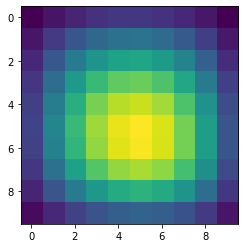

In [3]:
# environment model
env = PollutionModelEnvironment("water", 10, 10, seed=1)
env.evolve_speed = 1
env.p_pollution = 0.1
for i in range(100):
    env.proceed(1.0)
# setting it to unchanging
env.evolve_speed = 0
env.p_pollution = 0.0
plt.imshow(env.value)
# information model
#im = ScalarFieldInformationModel_stored_observation("sample", env.width, env.height, 
#                                estimation_type="disk-fixed", estimation_radius=2)
im = ScalarFieldInformationModel_stored_observation("sample", env.width, env.height, 
                                estimation_type="gaussian-process")
im.proceed(0)

In [4]:
world = World(env, im)
robot = Robot("Robi", 2, 3, 0, env=env, im=im)
# path = generate_lawnmower(0, 10, 0, 10, 5)
# robot.policy = FollowPathPolicy(None, robot, 1, path, repeat = True)
# robot.policy = GoToLocationPolicy(None, robot, 9, 9, 0.2)
# robot.policy = 
world.add_robot(robot)
robot = Robot("Robur", 4, 8, 0, env=env, im=im)
#robot.policy = RandomWaypointPolicy(None, robot, 1, [0,0], [9, 9], seed=1)
world.add_robot(robot)

#robot = Robot("R2D3", 5, 9, 0, env=env, im=im)
#robot.policy = FollowPathPolicy(None, robot, 1, [[0,0], [5, 5], [9,0]], repeat = True)
#world.add_robot(robot)

# Visualizing the world

In [5]:
visual_world = VisualWorld(world)
# visual_world.create_visualization()

In [6]:
world.env.value.shape

(10, 10)